# COVID-19 analysis

- <https://github.com/Kamaropoulos/covid19py>

Note that the JHU data source is not providing recovery data at this time ([reference](https://github.com/ExpDev07/coronavirus-tracker-api/blob/master/README.md#recovered-cases-showing-0)).

Another source of data might be the following: <https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data>

## data sources (acquired reliably from CERN)

```Bash
virtualenv -p python3.6 COVID19
source COVID19/bin/activate
pip3.6 install pip --upgrade
pip3.6 install jupyter matplotlib numpy pandas requests seaborn
pip3.6 install COVID19Py
python3.6

import COVID19Py
import numpy as np
import pandas as pd

import json
import pickle
from uuid import uuid4

def uuid4_short():
    return str(uuid4()).split('-')[0]

def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose:
        print(filename)
    return filename

#covid19 = COVID19Py.COVID19(data_source='jhu')
#covid19 = COVID19Py.COVID19('https://coronavirus-tracker-api.herokuapp.com')
covid19 = COVID19Py.COVID19()
data = covid19.getAll(timelines=True)

with open(new_filename(), 'wb') as f:
    pickle.dump(covid19, f)

with open(new_filename(), 'wb') as f:
    pickle.dump(data, f)
```

In [1]:
import json
import pickle
from uuid import uuid4
import warnings

import COVID19Py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.labelcolor'] = (1, 1, 1, 0)
pd.set_option("display.max_rows"   , 500)
pd.set_option("display.max_columns", 500)
sns.set_palette('husl')
sns.set(style='ticks')
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = [13, 6]
sns.set()

In [3]:
def uuid4_short():
    return str(uuid4()).split('-')[0]
def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose: print(filename)
    return filename

In [4]:
%%time
if 0:
    covid19 = COVID19Py.COVID19(data_source='jhu') # https://github.com/CSSEGISandData/COVID-19
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)
    data = covid19.getAll(timelines=True)
    data
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)
if 1:
    with open('8f0ec81a.pkl', 'rb') as f:
        covid19 = pickle.load(f)
    with open('741cd4d4.pkl', 'rb') as f:
        data = pickle.load(f)
    # records:
    # 2020-04-08T0616Z covid19: 8f0ec81a.pkl, data: 741cd4d4.pkl
    # 2020-04-07       covid19: f94e6997.pkl, data: 120141ce.pkl

#latest = covid19.getLatest()
#locations = covid19.getLocations(timelines=True)

df = pd.DataFrame(data['locations'])
df.head()
#df

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 10.5 ms


,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,29121286.0,,2020-04-08T06:09:55.013873Z,"{'latitude': '33.0', 'longitude': '65.0'}","{'confirmed': 423, 'deaths': 14, 'recovered': 0}","{'confirmed': {'latest': 423, 'timeline': {'20..."
1,1,Albania,AL,2986952.0,,2020-04-08T06:09:55.019560Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 383, 'deaths': 22, 'recovered': 0}","{'confirmed': {'latest': 383, 'timeline': {'20..."
2,2,Algeria,DZ,34586184.0,,2020-04-08T06:09:55.024141Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 1468, 'deaths': 193, 'recovered'...","{'confirmed': {'latest': 1468, 'timeline': {'2..."
3,3,Andorra,AD,84000.0,,2020-04-08T06:09:55.027795Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 545, 'deaths': 22, 'recovered': 0}","{'confirmed': {'latest': 545, 'timeline': {'20..."
4,4,Angola,AO,13068161.0,,2020-04-08T06:09:55.031710Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 17, 'deaths': 2, 'recovered': 0}","{'confirmed': {'latest': 17, 'timeline': {'202..."


In [5]:
locations = {}

In [6]:
def process(location):
    location = location['timelines'].values[0]

    confirmed = pd.DataFrame(list(location['confirmed']['timeline'].items()), columns=['datetime', 'confirmed'])
    deaths    = pd.DataFrame(list(location['deaths']['timeline'].items()),    columns=['datetime', 'deaths'])
    recovered = pd.DataFrame(list(location['recovered']['timeline'].items()), columns=['datetime', 'recovered'])

    confirmed.index = pd.to_datetime(confirmed['datetime']); del confirmed['datetime']
    deaths.index    = pd.to_datetime(deaths['datetime'])   ; del deaths['datetime']
    recovered.index = pd.to_datetime(recovered['datetime']); del recovered['datetime']

    # merge
    location = confirmed
    location['deaths']       = deaths['deaths']
    location['recovered']    = recovered['recovered']

    # visual estimate of changes (with linear interpolation)
    half_mean_of_confirmed_cases = location['confirmed'].mean()/2
    half_mean_of_deaths_cases    = location['confirmed'].mean()/2
    location['confirmed_percentage_change']                                     = location['confirmed'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['confirmed_percentage_change']                                     = 100*location['confirmed_percentage_change']
    location['confirmed_percentage_change_by_half_mean_confirmed_cases_factor'] = half_mean_of_confirmed_cases*location['confirmed_percentage_change']
    location['deaths_percentage_change']                                        = location['deaths'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['deaths_percentage_change']                                        = 100*location['deaths_percentage_change']
    location['deaths_percentage_change_by_half_mean_deaths_cases_factor']       = half_mean_of_confirmed_cases*location['deaths_percentage_change']

    # reindex to first confirmed case
    location = location.query('confirmed > 0').reset_index(); del location['datetime']

    #plots
    df_plot = location.drop([
        'confirmed_percentage_change',
        'confirmed_percentage_change_by_half_mean_confirmed_cases_factor',
        'deaths_percentage_change',
        'deaths_percentage_change_by_half_mean_deaths_cases_factor'], axis=1)
    df_plot.plot(title=location_name+' confirmed cases and deaths (linear scale)')                   ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
    df_plot.plot(title=location_name+' confirmed cases and deaths (log scale)', logy=True)           ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

    df_plot = location[['confirmed_percentage_change', 'deaths_percentage_change']]
    df_plot.plot(title=location_name+' percentage change in cases and deaths (linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
    df_plot.plot(title=location_name+' percentage change in cases and deaths (log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

    return location

# South Korea

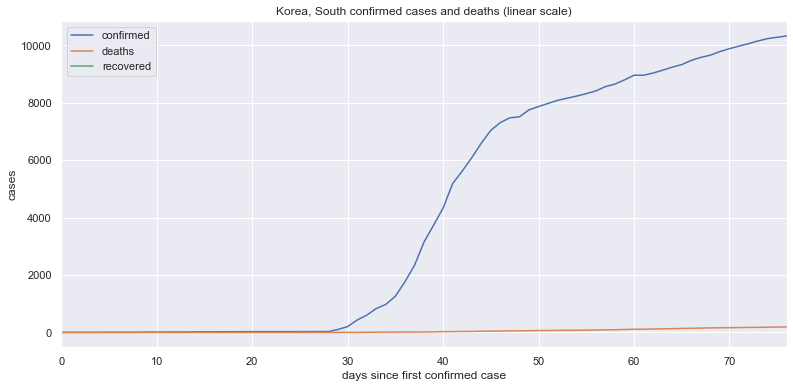

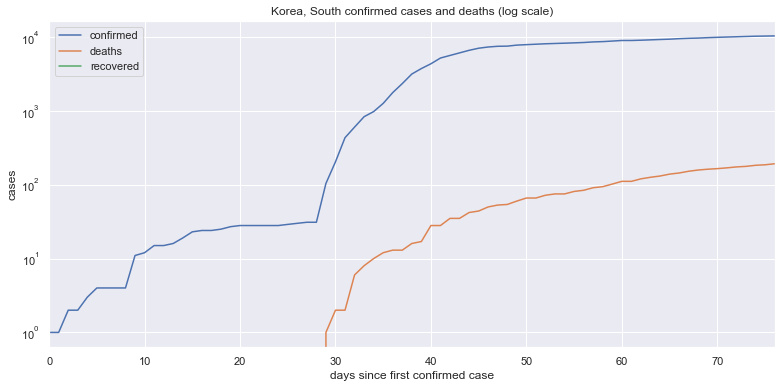

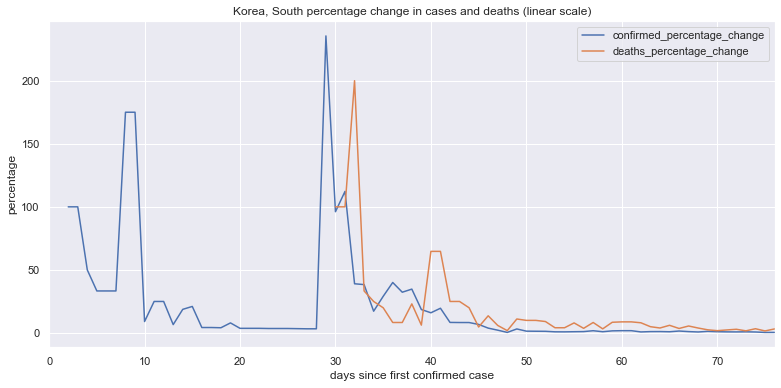

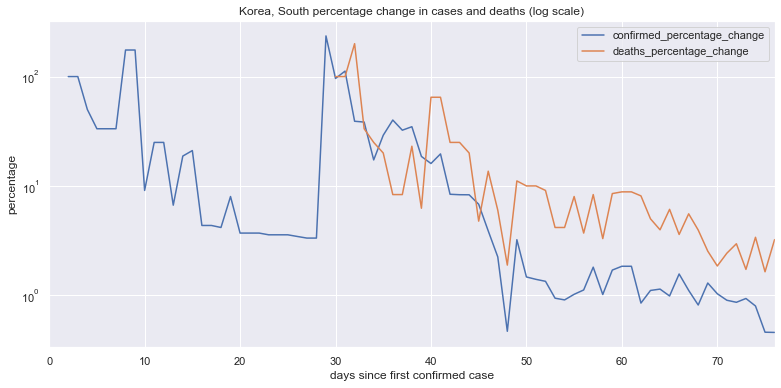

In [7]:
location_name = 'Korea, South'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Sweden

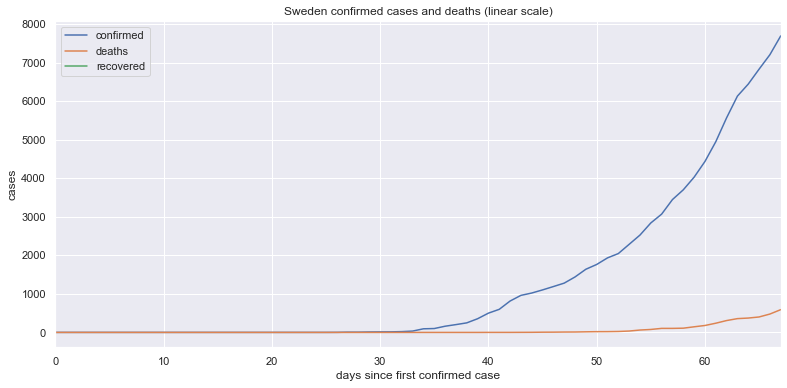

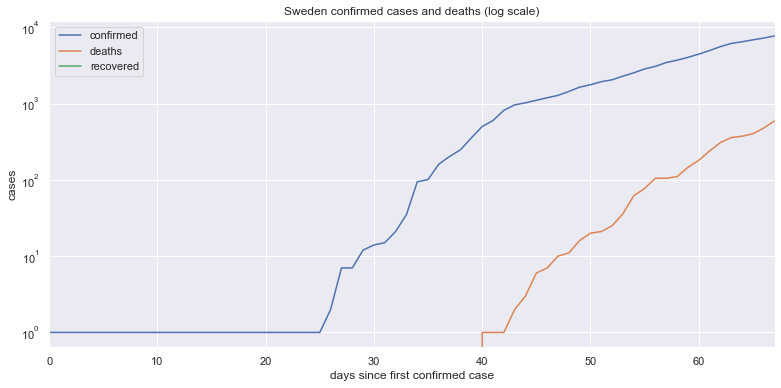

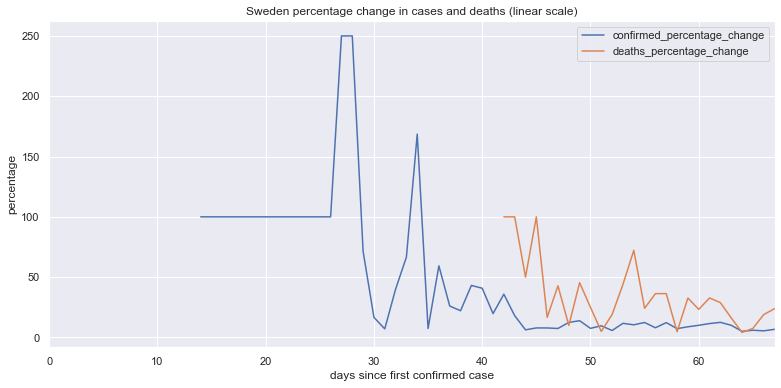

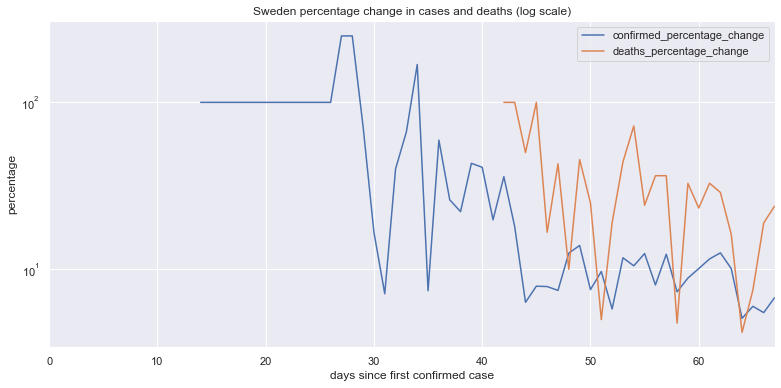

In [8]:
location_name = 'Sweden'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Ireland

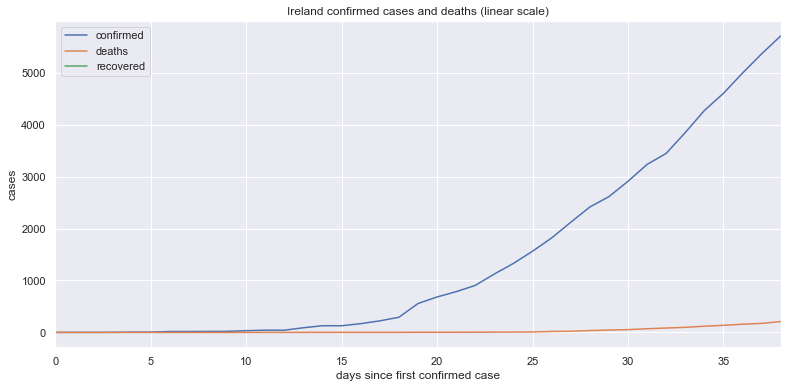

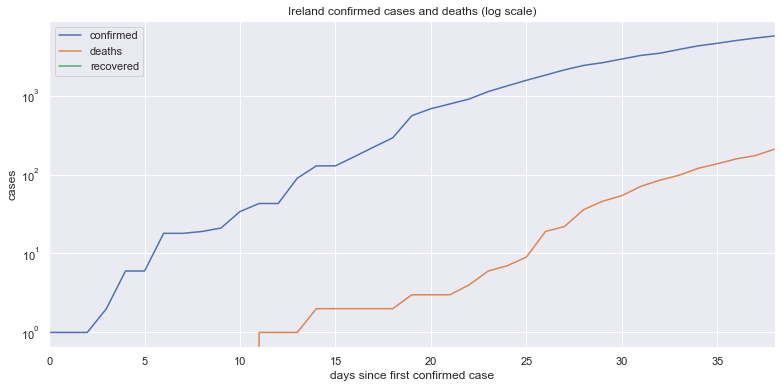

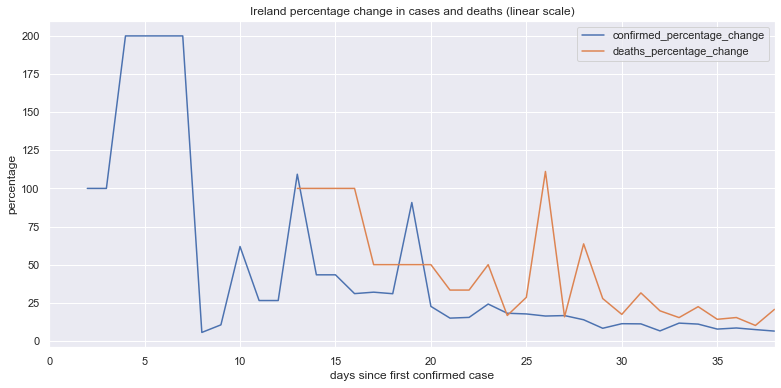

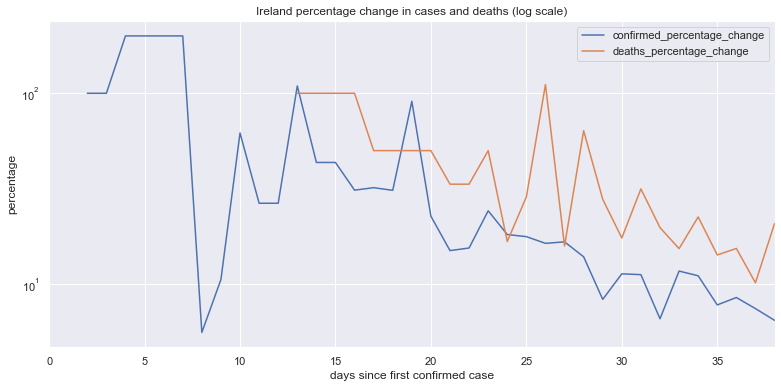

In [9]:
location_name = 'Ireland'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United Kingdom (approximate)

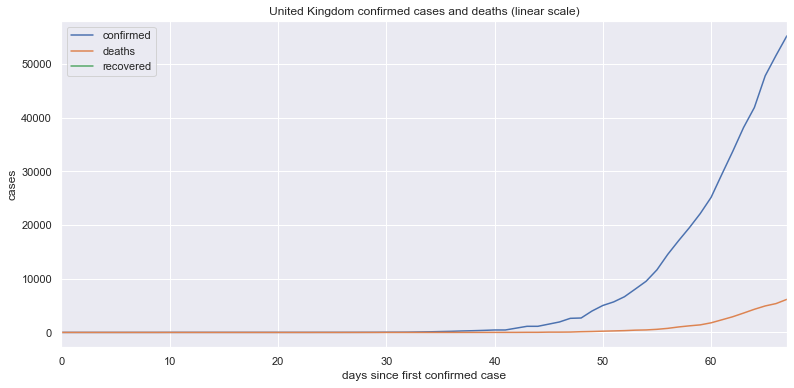

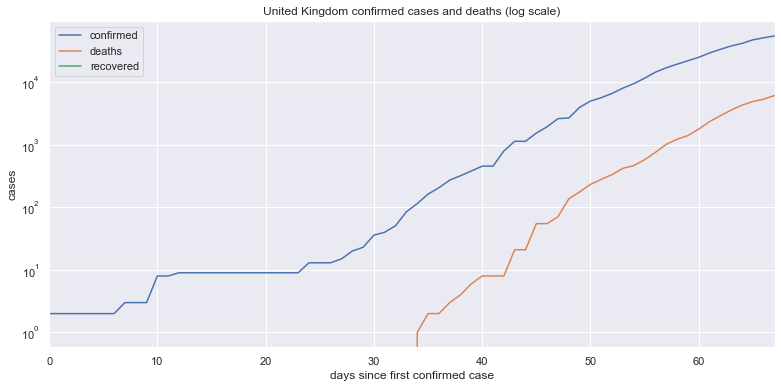

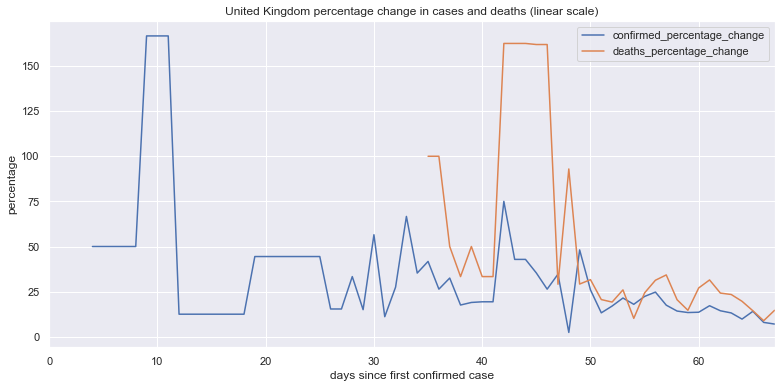

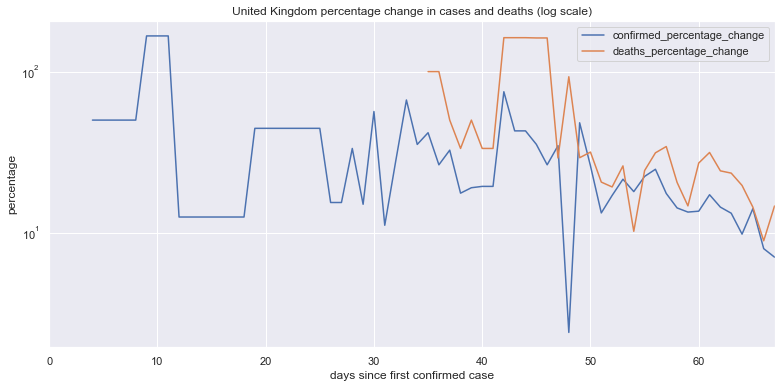

In [10]:
location_name = 'United Kingdom'
#location = df.query('country == @location_name')
location = df.query('country in ["United Kingdom"] and province == ""')
location = process(location)
locations[location_name] = location

# Germany

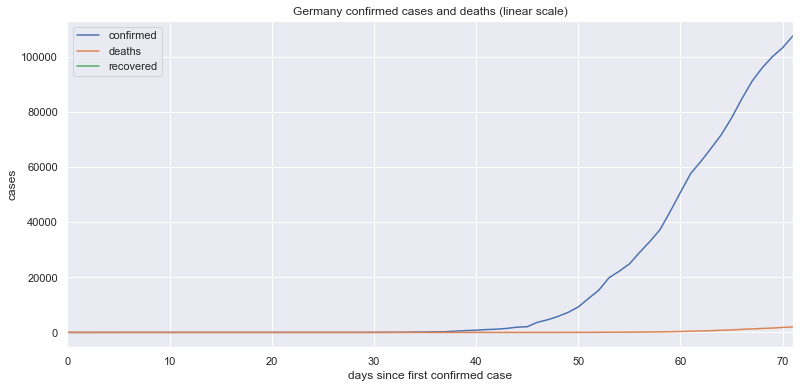

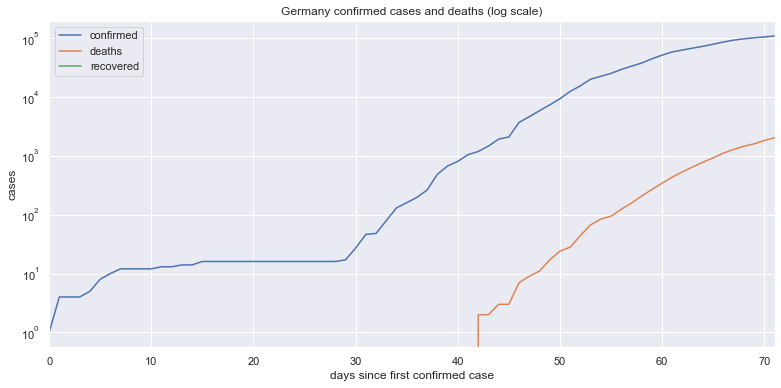

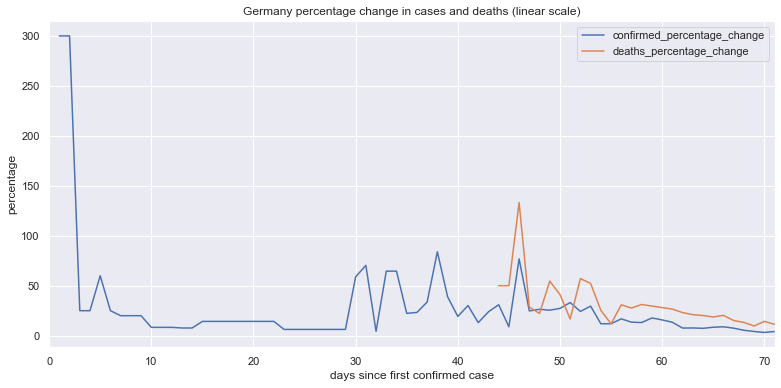

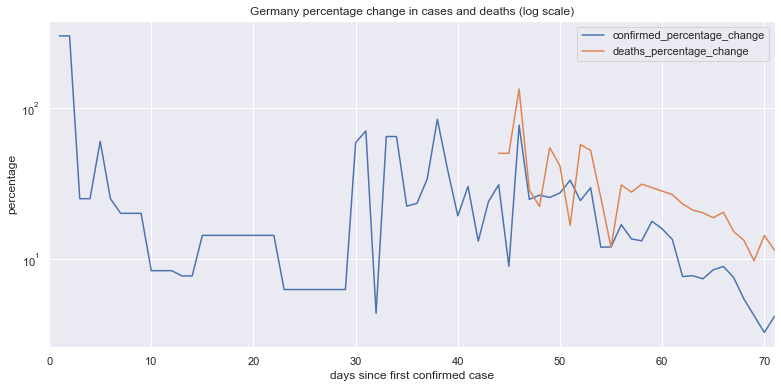

In [11]:
location_name = 'Germany'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Italy

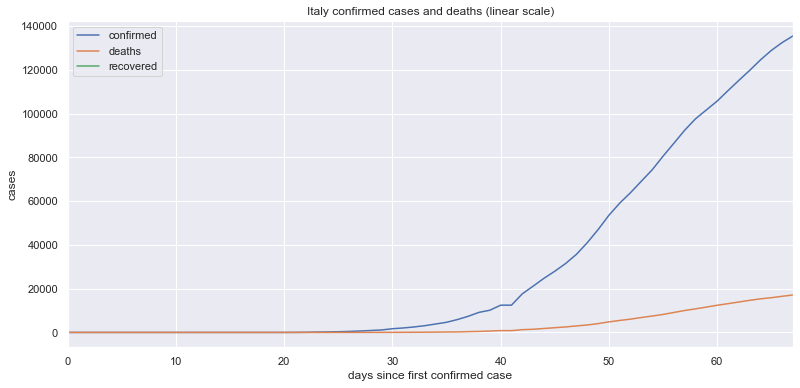

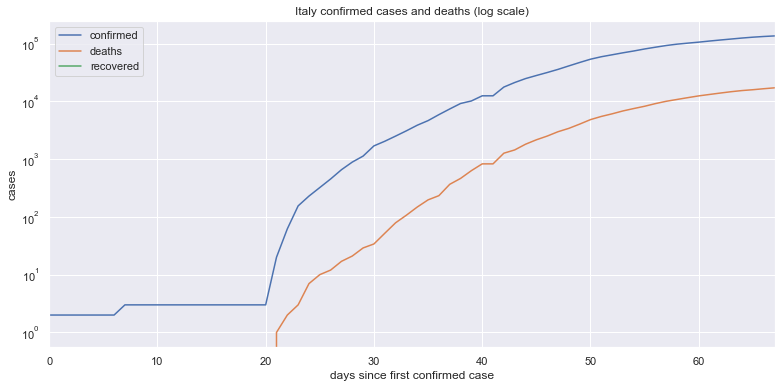

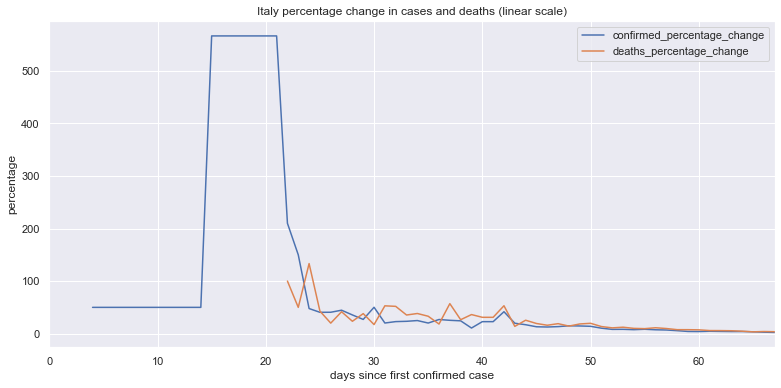

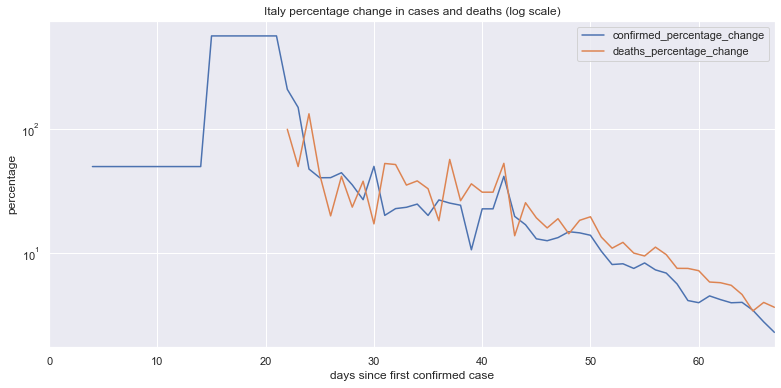

In [12]:
location_name = 'Italy'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United States of America

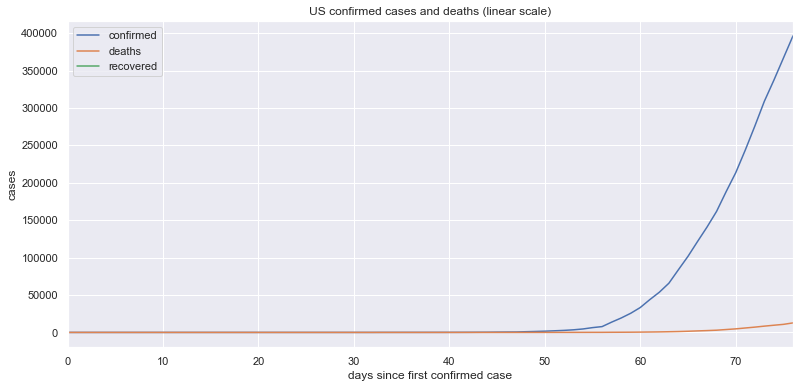

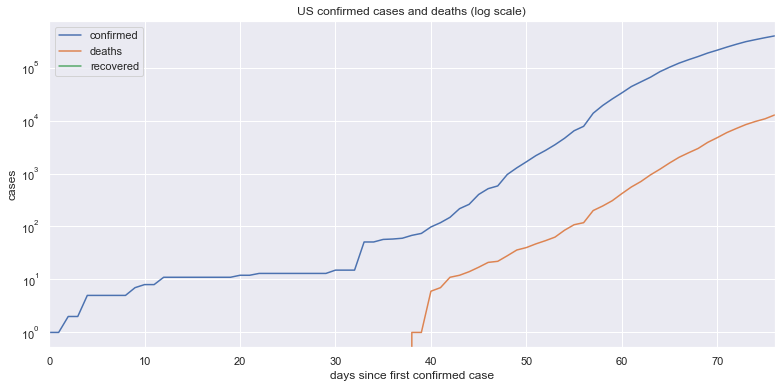

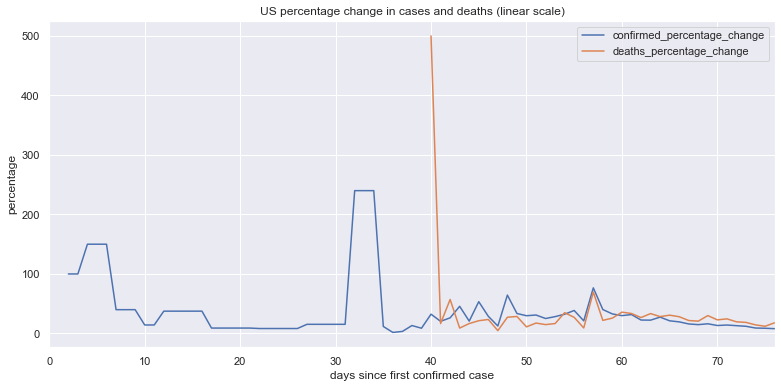

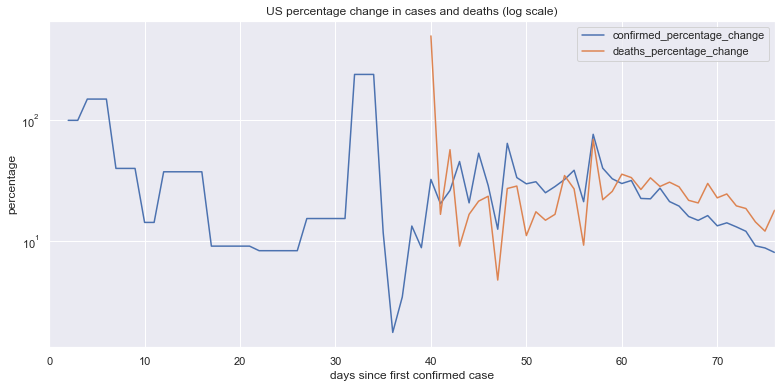

In [13]:
location_name = 'US'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

---

In [14]:
South_Korea              = locations['Korea, South']
Sweden                   = locations['Sweden']
Ireland                  = locations['Ireland']
United_Kingdom           = locations['United Kingdom']
Germany                  = locations['Germany']
Italy                    = locations['Italy']
United_States_of_America = locations['US']

locations_list           = [South_Korea,
                            Sweden,
                            Ireland,
                            United_Kingdom,
                            Germany,
                            Italy,
                            United_States_of_America]

In [15]:
South_Korea

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
0,1,0,NaN,NaN,NaN,NaN,NaN
1,1,0,NaN,NaN,NaN,NaN,NaN
2,2,0,NaN,100.000000,212996.753247,NaN,NaN
3,2,0,NaN,100.000000,212996.753247,NaN,NaN
4,3,0,NaN,50.000000,106498.376623,NaN,NaN
5,4,0,NaN,33.333333,70998.917749,NaN,NaN
6,4,0,NaN,33.333333,70998.917749,NaN,NaN
7,4,0,NaN,33.333333,70998.917749,NaN,NaN
8,4,0,NaN,175.000000,372744.318182,NaN,NaN
9,11,0,NaN,175.000000,372744.318182,NaN,NaN


In [16]:
_df = pd.merge(South_Korea.add_suffix('_South_Korea'), Sweden.add_suffix('_Sweden'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Ireland.add_suffix('_Ireland'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, United_Kingdom.add_suffix('_United_Kingdom'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Germany.add_suffix('_Germany'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, Italy.add_suffix('_Italy'), how='inner', left_index=True, right_index=True)
_df = pd.merge(_df, United_States_of_America.add_suffix('_United_States_of_America'), how='inner', left_index=True, right_index=True)
_df.tail()

,confirmed_South_Korea,deaths_South_Korea,recovered_South_Korea,confirmed_percentage_change_South_Korea,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_South_Korea,deaths_percentage_change_South_Korea,deaths_percentage_change_by_half_mean_deaths_cases_factor_South_Korea,confirmed_Sweden,deaths_Sweden,recovered_Sweden,confirmed_percentage_change_Sweden,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Sweden,deaths_percentage_change_Sweden,deaths_percentage_change_by_half_mean_deaths_cases_factor_Sweden,confirmed_Ireland,deaths_Ireland,recovered_Ireland,confirmed_percentage_change_Ireland,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Ireland,deaths_percentage_change_Ireland,deaths_percentage_change_by_half_mean_deaths_cases_factor_Ireland,confirmed_United_Kingdom,deaths_United_Kingdom,recovered_United_Kingdom,confirmed_percentage_change_United_Kingdom,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_Kingdom,deaths_percentage_change_United_Kingdom,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_Kingdom,confirmed_Germany,deaths_Germany,recovered_Germany,confirmed_percentage_change_Germany,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Germany,deaths_percentage_change_Germany,deaths_percentage_change_by_half_mean_deaths_cases_factor_Germany,confirmed_Italy,deaths_Italy,recovered_Italy,confirmed_percentage_change_Italy,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Italy,deaths_percentage_change_Italy,deaths_percentage_change_by_half_mean_deaths_cases_factor_Italy,confirmed_United_States_of_America,deaths_United_States_of_America,recovered_United_States_of_America,confirmed_percentage_change_United_States_of_America,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_States_of_America,deaths_percentage_change_United_States_of_America,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_States_of_America
34,977,10,NaN,17.286915,36820.567188,25.000000,53249.188312,94,0,NaN,168.571429,97135.454545,NaN,NaN,4273,120,NaN,11.015848,3973.502310,22.448980,8097.521866,115,1,NaN,35.294118,105808.097785,inf,inf,130,0,NaN,64.556962,523932.146967,NaN,NaN,3858,148,NaN,24.894788,335989.919194,38.317757,517151.626411,51,0,NaN,240.000000,5.031835e+06,NaN,NaN
35,1261,12,NaN,29.068577,61915.125816,20.000000,42599.350649,101,0,NaN,7.446809,4291.054159,NaN,NaN,4604,137,NaN,7.746314,2794.155844,14.166667,5110.027056,163,2,NaN,41.739130,125129.576510,100.000000,2.997896e+05,159,0,NaN,22.307692,181045.029970,NaN,NaN,4636,197,NaN,20.165889,272166.826564,33.108108,446840.141278,57,0,NaN,11.764706,2.466586e+05,NaN,NaN
36,1766,13,NaN,40.047581,85300.047890,8.333333,17749.729437,161,0,NaN,59.405941,34231.323132,NaN,NaN,4994,158,NaN,8.470895,3055.517788,15.328467,5529.097545,206,2,NaN,26.380368,79085.602741,100.000000,2.997896e+05,196,0,NaN,23.270440,188858.510986,NaN,NaN,5883,233,NaN,26.898188,363028.600983,18.274112,246634.649614,58,0,NaN,1.754386,3.678242e+04,NaN,NaN
37,2337,13,NaN,32.332956,68868.146152,8.333333,17749.729437,203,0,NaN,26.086957,15032.015810,NaN,NaN,5364,174,NaN,7.408891,2672.444596,10.126582,3652.737136,273,3,NaN,32.524272,97504.387845,50.000000,1.498948e+05,262,0,NaN,33.673469,273287.536443,NaN,NaN,7375,366,NaN,25.361210,342284.939436,57.081545,770395.142411,60,0,NaN,3.448276,7.229648e+04,NaN,NaN
38,3150,16,NaN,34.788190,74097.715186,23.076923,49153.096903,248,0,NaN,22.167488,12773.510972,NaN,NaN,5709,210,NaN,6.431767,2319.988596,20.689655,7462.919839,321,4,NaN,17.582418,52710.261167,33.333333,9.992987e+04,482,0,NaN,83.969466,681480.370774,NaN,NaN,9172,463,NaN,24.366102,328854.559982,26.502732,357691.372152,68,1,NaN,13.333333,2.795464e+05,inf,inf


# comparisons: confirmed cases

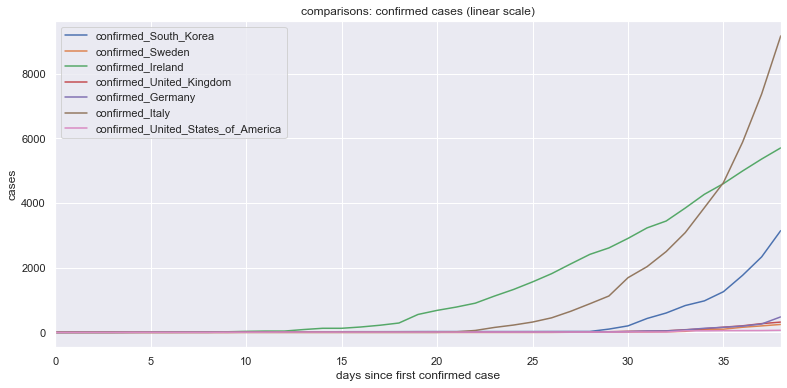

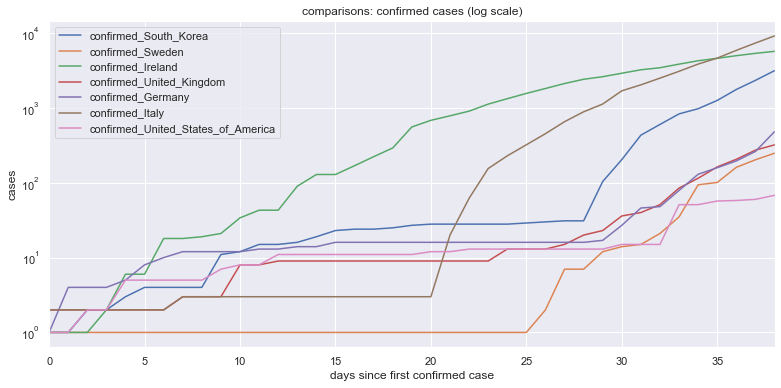

In [17]:
__df = _df[[
    'confirmed_South_Korea',
    'confirmed_Sweden',
    'confirmed_Ireland',
    'confirmed_United_Kingdom',
    'confirmed_Germany',
    'confirmed_Italy',
    'confirmed_United_States_of_America']]

title = 'comparisons: confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: deaths

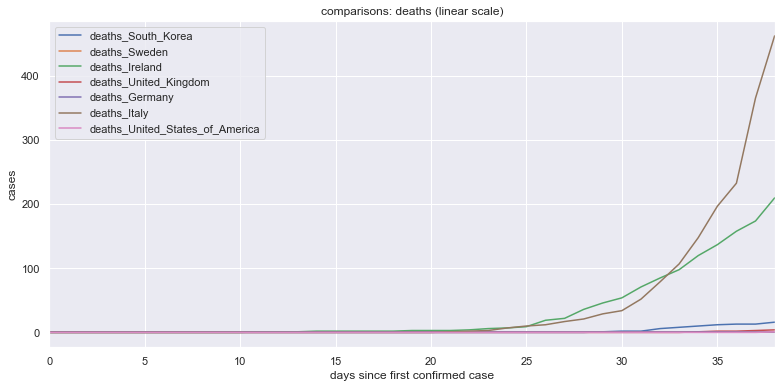

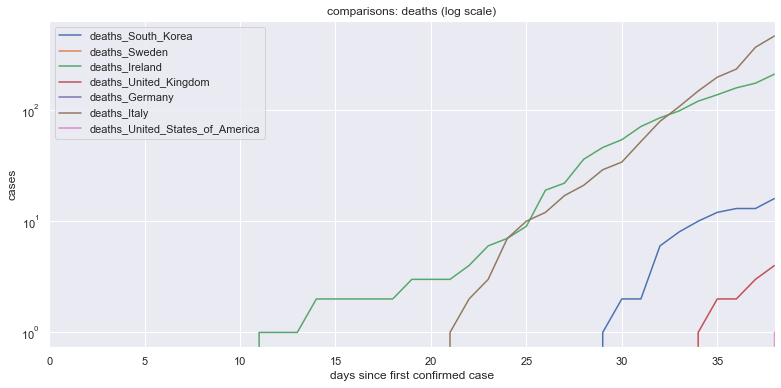

In [18]:
__df = _df[[
    'deaths_South_Korea',
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy',
    'deaths_United_States_of_America']]
__df.tail()

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

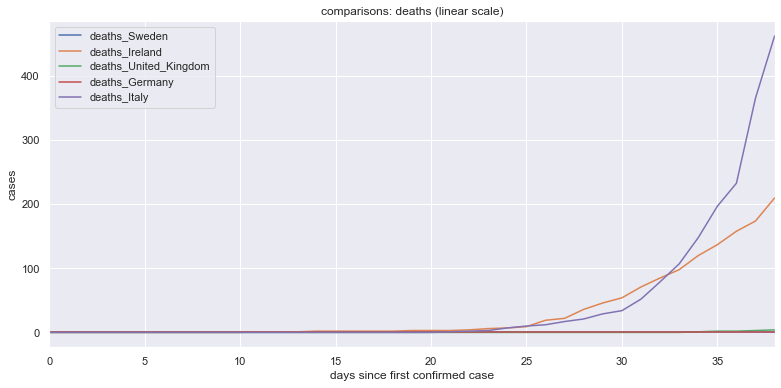

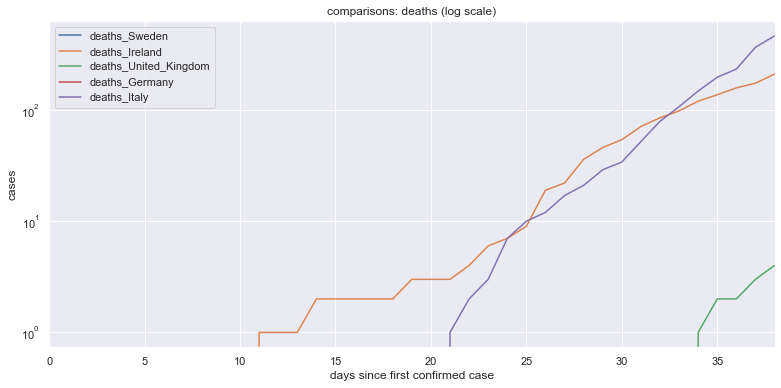

In [19]:
# some EU countries
__df = _df[[
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy']]
__df.tail()

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: changes in confirmed cases

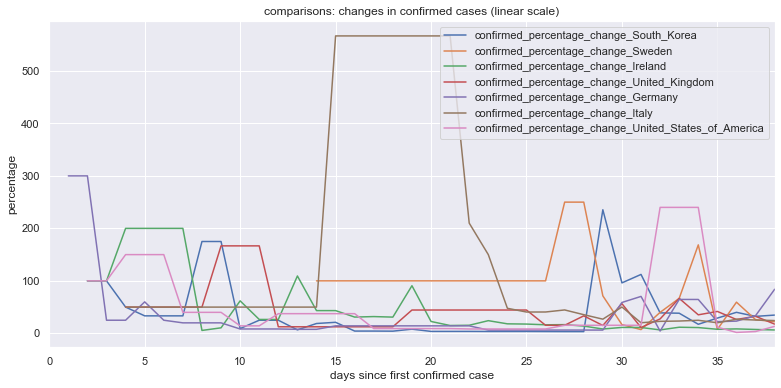

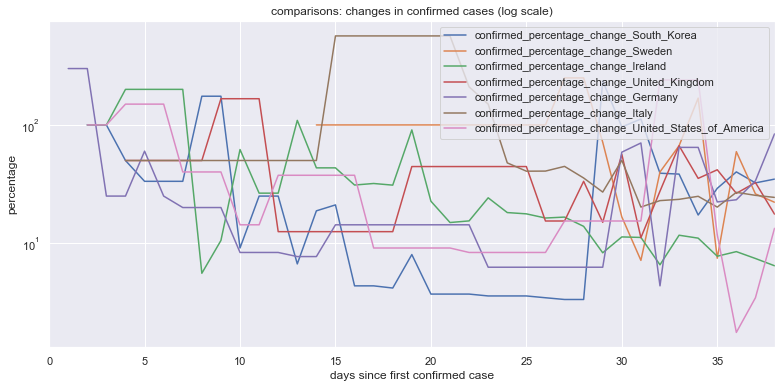

In [20]:
__df = _df[[
    'confirmed_percentage_change_South_Korea',
    'confirmed_percentage_change_Sweden',
    'confirmed_percentage_change_Ireland',
    'confirmed_percentage_change_United_Kingdom',
    'confirmed_percentage_change_Germany',
    'confirmed_percentage_change_Italy',
    'confirmed_percentage_change_United_States_of_America']]
__df.tail()

title = 'comparisons: changes in confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

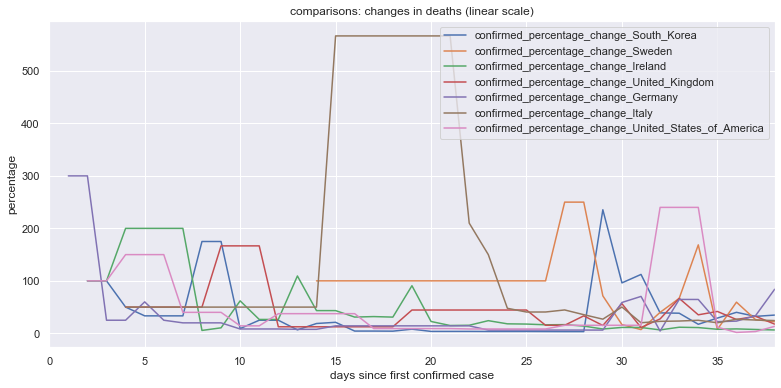

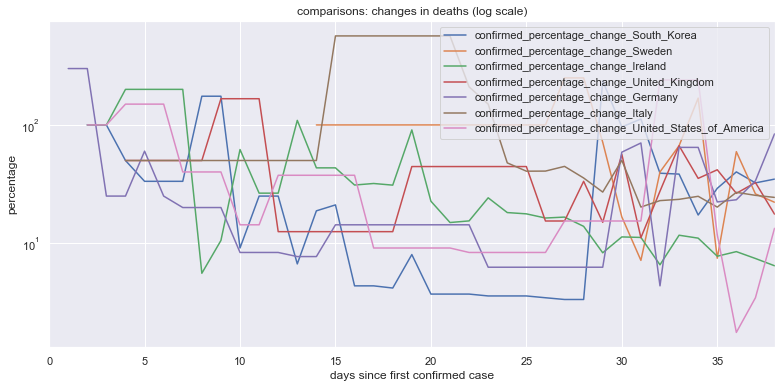

In [21]:
___df = _df[[
    'deaths_percentage_change_South_Korea',
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy',
    'deaths_percentage_change_United_States_of_America']]
___df.tail()

title = 'comparisons: changes in deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

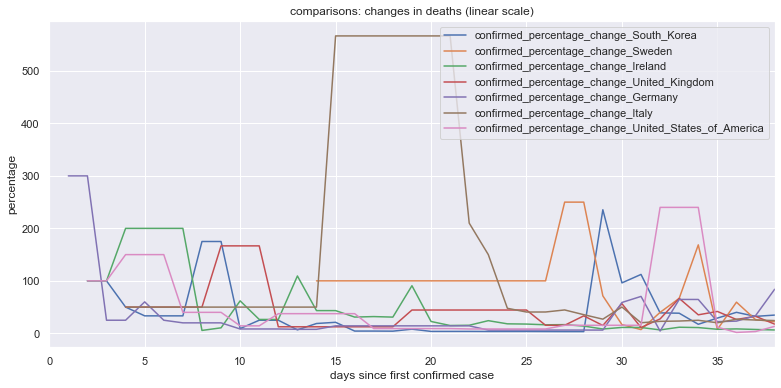

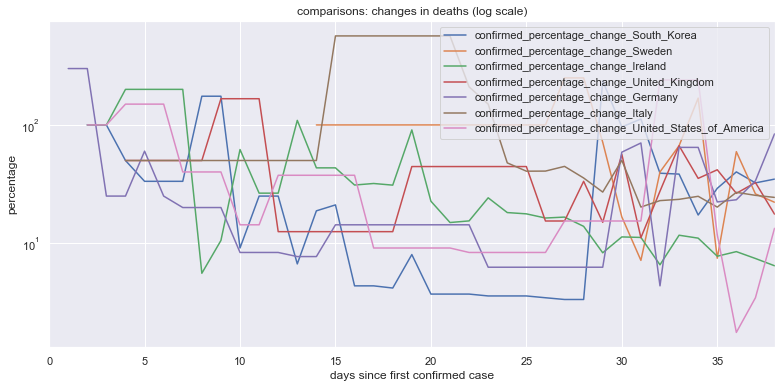

In [22]:
# some EU countries
___df = _df[[
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy']]
___df.tail()

title = 'comparisons: changes in deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');